In [3]:
# clear modules
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [4]:
import sys
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # silence warning logs
singularity_name = os.environ.get("SINGULARITY_NAME")
if singularity_name: print("Singularity:\t", singularity_name)    
print("version_info:\t", sys.version_info)
print("executable:\t",sys.executable)
print("pwd:\t\t", os.getcwd())

Singularity:	 TensorFlow:25.02-tf2-py3.SIF
version_info:	 sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
executable:	 /usr/bin/python
pwd:		 /auto/brno2/home/romova9


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ndnoise
import random
from numbers import Number
from typing import Optional
from pathlib import Path
import scipy
import cv2
import skimage.transform
import nibabel
import h5py
import json

from PIL import Image
from loguru import logger
import io3d
import io3d.datasets
logger.enable("io3d")
logger.disable("io3d")

#from skimage.filters import threshold_otsu
#from scipy.ndimage import gaussian_filter
#from scipy.ndimage import zoom

def window(
    data3d: np.ndarray,
    vmin: Optional[Number] = None,
    vmax: Optional[Number] = None,
    center: Optional[Number] = None,
    width: Optional[Number] = None,
    vmin_out: Optional[Number] = 0,
    vmax_out: Optional[Number] = 255,
    dtype=np.uint8,
):
    """
    Rescale input ndarray and trim the outlayers. Used for image intensity windowing.
    :param data3d: ndarray with numbers
    :param vmin: minimal input value. Skipped if center and width is given.
    :param vmax: maximal input value. Skipped if center and width is given.
    :param center: Window center
    :param width: Window width
    :param vmin_out: Output mapping minimal value
    :param vmax_out: Output mapping maximal value
    :param dtype: Output dtype
    :return:
    """
    if width and center:
        vmin = center - (width / 2.0)
        vmax = center + (width / 2.0)

    # logger.debug(f"vmin={vmin}, vmax={vmax}")
    k = float(vmax_out - vmin_out) / (vmax - vmin)
    q = vmax_out - k * vmax
    # logger.debug(f"k={k}, q={q}")
    data3d_out = data3d * k + q

    data3d_out[data3d_out > vmax_out] = vmax_out
    data3d_out[data3d_out < vmin_out] = vmin_out

    return data3d_out.astype(dtype)

def noisegenerator(shape):
    noise = ndnoise.generator.noises(
        shape,
        sample_spacing=[1,1,1],
        #random_generator_seed=5,
        lambda0=1,  # nastavení hrubeho sumu v pixelech
        lambda1=16, # vzdálenost shluků (rozptyl?)
        exponent=0, # prudkost rozdílu v
        method="space"
    )
    noise = (noise+abs(np.min(noise))) # na kladne hodnoty
    noise = noise/np.max(noise) # rozptyl 0-1
    return np.array(noise)

def noisegenerator_standart(shape):
    data0 = np.random.random(shape)  # or however you generate your noise
    # Ensure sigma is a sequence of length equal to the input rank (number of dimensions)
    sigma = [1] * len(data0.shape)  # create a sequence with length equal to the number of dimensions of data0
    noise = scipy.ndimage.gaussian_filter(data0, sigma=sigma)
    return noise

In [6]:
def load_nii_as_numpy(file_path):
    """Load a NIfTI (.nii.gz) file as a NumPy array."""
    nii_img = nibabel.load(file_path)  # Load the NIfTI image
    data = nii_img.get_fdata()  # Get the image data as a NumPy array
    return data

def split_files(files, train_ratio=0.8):
    """Randomly split files into training and validation sets based on the given ratio."""
    random.shuffle(files)
    split_index = int(len(files) * train_ratio)
    train_files = files[:split_index]
    val_files = files[split_index:]
    return train_files, val_files

def resample_to_voxelsize(img_np, original_spacing, target_spacing=(1.0, 1.0, 1.0), order=3):
    zoom_factors = [o / t for o, t in zip(original_spacing, target_spacing)]
    return scipy.ndimage.zoom(img_np, zoom_factors, order=order)


def image_generator_deepvesselnet(ct_ids, batch_size, shape=(128, 256, 256)):
    """Deepvesselnet"""
    while True:
        dataset = '2D_to_3D/data/deepvesselnet'
        batch_data_raw = []
        batch_data_mask = []
        
        for _ in range(batch_size):
            # Randomly choose a CT scan ID.
            ct_id = ct_ids[np.random.choice(range(len(ct_ids)), size=1)[0]]
            
            # Load CT data.
            raw_p = load_nii_as_numpy(dataset + '/raw/' + ct_id)  
            dataRaw = window(raw_p, center=40, width=400)
            
            # Determine cropping coordinates.
            # If the data is smaller than the desired shape, we set the offset to 0.
            x_max = max(dataRaw.shape[0] - shape[0], 0)
            y_max = max(dataRaw.shape[1] - shape[1], 0)
            z_max = max(dataRaw.shape[2] - shape[2], 0)
            xscale = random.randrange(0, x_max + 1)  # +1 to include endpoint
            yscale = random.randrange(0, y_max + 1)
            zscale = random.randrange(0, z_max + 1)
            
            # Crop raw data.
            cropped_dataRaw = dataRaw[xscale:xscale + shape[0],
                                      yscale:yscale + shape[1],
                                      zscale:zscale + shape[2]]
           
            # Process and combine mask data from multiple parameters.
            mask_data = load_nii_as_numpy(dataset + '/seg/' + ct_id)*255

            # Crop the mask using the same coordinates.
            mask_data = mask_data[xscale:xscale + shape[0], yscale:yscale + shape[1], zscale:zscale + shape[2]]
            # Threshold to obtain a binary mask.
            mask_data = (mask_data > 0.5).astype(np.float32)
            background = 1 - mask_data
            # Create an array with shape (x, y, z, 2) for background and foreground.
            dataMask = np.zeros(mask_data.shape + (2,), dtype=np.float32)
            dataMask[..., 0] = mask_data  # Channel 0: foreground
            dataMask[..., 1] = background   # Channel 1: background
            
            # Optionally apply noise.
            if random.randint(0, 1) > 0:
                cropped_dataRaw = (cropped_dataRaw + noisegenerator(cropped_dataRaw.shape)) / 2
                
            # Process raw data: add channel dimension and replicate to form 3 channels.
            cropped_dataRaw = np.expand_dims(cropped_dataRaw, axis=-1)  # (x,y,z,1)
            cropped_dataRaw = np.concatenate([cropped_dataRaw] * 3, axis=-1)  # (x,y,z,3)
            cropped_dataRaw = np.clip(cropped_dataRaw, 0, 255).astype(np.float32) / 255.0
            
            # Append processed sample to the batch.
            batch_data_raw.append(cropped_dataRaw)
            batch_data_mask.append(dataMask)
            
            #print(np.min(cropped_dataRaw), np.max(cropped_dataRaw), len(np.unique(cropped_dataRaw)))
            #print(np.min(mask_data), np.max(mask_data), len(np.unique(mask_data)))
            #print(np.min(background), np.max(background), len(np.unique(background)))
            #print()
                
        # Convert lists to numpy arrays.
        batch_data_raw = np.array(batch_data_raw, dtype=np.float32)
        batch_data_mask = np.array(batch_data_mask, dtype=np.float32)
        
        if batch_data_raw.shape[1:4] != shape:
                batch_data_raw = np.resize(batch_data_raw, (batch_size, shape[0], shape[1], shape[2], 3))
        if batch_data_mask.shape[1:4] != shape:
            batch_data_mask = np.resize(batch_data_mask, (batch_size, shape[0], shape[1], shape[2], 2))
               
        yield batch_data_raw, batch_data_mask

In [7]:
def image_generator(ct_ids, promenne, batch_size, shape=(128, 256, 256)):
    """
    Generator that yields batches of CT data and corresponding segmentation masks. -> 3x kanal
    
    The output masks have shape (batch_size, x, y, z, num_classes), where num_classes=2:
      - Channel 0 is background.
      - Channel 1 is foreground.
    
    Parameters:
      ct_ids    : List of CT scan IDs.
      promenne  : List of dataset names (first element is ignored).
      batch_size: Number of samples per batch.
      shape     : Target crop shape (x, y, z).
    """
    # Skip the first element if it is not used.
    promenne = np.array(promenne[1:])
    new_voxelsize_mm = [1, 1, 1]
    
    while True:
        batch_data_raw = []
        batch_data_mask = []
        
        for _ in range(batch_size):
            # Randomly choose a CT scan ID.
            ct_id = np.random.choice(ct_ids)
            
            # Load CT data.
            dataset_path = io3d.datasets.get_dataset_path("3Dircadb1", "data3d", ct_id)
            raw_p = io3d.read(dataset_path)
            dataRaw = window(raw_p.data3d, center=40, width=400)
            dataRaw = io3d.image_manipulation.resize_to_mm(
                dataRaw,
                voxelsize_mm=raw_p.voxelsize_mm,
                new_voxelsize_mm=new_voxelsize_mm
            )
            #print(dataRaw.shape)
            
            # Determine cropping coordinates.
            # If the data is smaller than the desired shape, we set the offset to 0.
            x_max = max(dataRaw.shape[0] - shape[0], 0)
            y_max = max(dataRaw.shape[1] - shape[1], 0)
            z_max = max(dataRaw.shape[2] - shape[2], 0)
            xscale = random.randrange(0, x_max + 1)  # +1 to include endpoint
            yscale = random.randrange(0, y_max + 1)
            zscale = random.randrange(0, z_max + 1)
            
            # Crop raw data.
            cropped_dataRaw = dataRaw[xscale:xscale + shape[0],
                                      yscale:yscale + shape[1],
                                      zscale:zscale + shape[2]]
           
            # Process and combine mask data from multiple parameters.
            mask_data = np.zeros(shape)
            for param in promenne:
                mask_datal = io3d.read_dataset("3Dircadb1", param, ct_id).data3d
                mask_datal = io3d.image_manipulation.resize_to_mm(
                    mask_datal,
                    voxelsize_mm=raw_p.voxelsize_mm,
                    new_voxelsize_mm=new_voxelsize_mm
                )
                # Crop the mask using the same coordinates.
                mask_datal = mask_datal[xscale:xscale + shape[0],
                                         yscale:yscale + shape[1],
                                         zscale:zscale + shape[2]]
                # Threshold to obtain a binary mask.
                mask_data = mask_datal + mask_data
                
            mask_data = (mask_data > 0.2).astype(np.float32)
            background = 1 - mask_data
            # Create an array with shape (x, y, z, 2) for background and foreground.
            dataMask = np.zeros(mask_data.shape + (2,), dtype=np.float32)
            dataMask[..., 0] = mask_data  # Channel 0: foreground
            dataMask[..., 1] = background   # Channel 1: background
            
            # Optionally apply noise.
            if random.randint(0, 1) > 0:
                cropped_dataRaw = (cropped_dataRaw + noisegenerator(cropped_dataRaw.shape)) / 2
                
            # Process raw data: add channel dimension and replicate to form 3 channels.
            cropped_dataRaw = np.expand_dims(cropped_dataRaw, axis=-1)  # (x,y,z,1)
            cropped_dataRaw = np.concatenate([cropped_dataRaw] * 3, axis=-1)  # (x,y,z,3)
            cropped_dataRaw = np.clip(cropped_dataRaw, 0, 255).astype(np.float32) / 255.0
            
            # Append processed sample to the batch.
            batch_data_raw.append(cropped_dataRaw)
            batch_data_mask.append(dataMask)
                
        # Convert lists to numpy arrays.
        batch_data_raw = np.array(batch_data_raw, dtype=np.float32)
        batch_data_mask = np.array(batch_data_mask, dtype=np.float32)
        
        if batch_data_raw.shape[1:4] != shape:
                batch_data_raw = np.resize(batch_data_raw, (batch_size, shape[0], shape[1], shape[2], 3))
        if batch_data_mask.shape[1:4] != shape:
            batch_data_mask = np.resize(batch_data_mask, (batch_size, shape[0], shape[1], shape[2], 2))
               
        yield batch_data_raw, batch_data_mask

In [8]:
def image_generator_pilsen_pigs(ct_ids, batch_size, shape=(128, 256, 256)):
    """Pilsen Pigs generator with 3-channel windowed input and voxel size resampling."""

    dataset = '2D_to_3D/data/pilsen_pigs'

    while True:
        batch_data_raw = []
        batch_data_mask = []

        # Random CT
        ct_id = ct_ids[np.random.choice(len(ct_ids))]

        # Load raw volume
        raw_nii = nib.load(f'{dataset}/{ct_id}/{ct_id}.nii.gz')
        raw = raw_nii.get_fdata()
        spacing = raw_nii.header.get_zooms()[:3]  # (z, y, x)

        # Load mask
        mask_nii = nib.load(f'{dataset}/{ct_id}/artery.nii.gz')
        mask = (mask_nii.get_fdata() > 0.5).astype(np.float32)

        # Resample to 1mm voxel size
        raw = resample_to_voxelsize(raw, spacing, target_spacing=(1.0, 1.0, 1.0), order=3)
        mask = resample_to_voxelsize(mask, spacing, target_spacing=(1.0, 1.0, 1.0), order=0)

        # Apply 3 windowing levels
        ch1 = window(raw, center=40, width=350, vmin_out=0, vmax_out=255, dtype=np.uint8)
        ch2 = window(raw, center=60, width=150, vmin_out=0, vmax_out=255, dtype=np.uint8)
        ch3 = window(raw, center=110, width=110, vmin_out=0, vmax_out=255, dtype=np.uint8)

        # Pad each channel and mask
        pad_shape = np.maximum(shape, raw.shape)
        pads = [(0, t - s) for s, t in zip(raw.shape, pad_shape)]

        ch1 = np.pad(ch1, pads, mode='constant')
        ch2 = np.pad(ch2, pads, mode='constant')
        ch3 = np.pad(ch3, pads, mode='constant')
        mask = np.pad(mask, pads, mode='constant')

        for _ in range(batch_size):
            # Random crop
            x = random.randint(0, ch1.shape[0] - shape[0])
            y = random.randint(0, ch1.shape[1] - shape[1])
            z = random.randint(0, ch1.shape[2] - shape[2])

            crop1 = ch1[x:x+shape[0], y:y+shape[1], z:z+shape[2]]
            crop2 = ch2[x:x+shape[0], y:y+shape[1], z:z+shape[2]]
            crop3 = ch3[x:x+shape[0], y:y+shape[1], z:z+shape[2]]
            crop_mask = mask[x:x+shape[0], y:y+shape[1], z:z+shape[2]]

            # Optional noise
            if random.randint(0, 1):
                crop1 = (crop1 + noisegenerator(crop1.shape)) / 2.0
                crop2 = (crop2 + noisegenerator(crop2.shape)) / 2.0
                crop3 = (crop3 + noisegenerator(crop3.shape)) / 2.0

            # Stack and normalize to [0, 1]
            crop_rgb = np.stack([crop1, crop2, crop3], axis=-1).astype(np.float32) / 255.0

            # 2-channel mask: foreground / background
            background = 1.0 - crop_mask
            crop_mask_2ch = np.stack([crop_mask, background], axis=-1)

            batch_data_raw.append(crop_rgb)
            batch_data_mask.append(crop_mask_2ch)

        yield np.array(batch_data_raw), np.array(batch_data_mask)


In [9]:
def visualize_batch(batch_x, batch_y):
    """Visualize a batch of 3D images."""
    batch_size = batch_x.shape[0]
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        print(batch_x[i].shape, np.min(batch_x), np.max(batch_x))
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_x[i][batch_x.shape[0]//2, :, :, 0], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X - Axial")

        axes[i, 1].imshow(batch_x[i][:, batch_x.shape[1]//2, :, 1], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y - Coronal")

        axes[i, 2].imshow(batch_x[i][:, :, batch_x.shape[2]//2, 2], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z - Sagital")
    plt.show()
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        print(batch_y[i].shape, np.min(batch_y), np.max(batch_y))
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_y[i][batch_y.shape[0]//2, :, :, 0], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X")

        axes[i, 1].imshow(batch_y[i][:, batch_y.shape[1]//2, :, 0], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y")

        axes[i, 2].imshow(batch_y[i][:, :, batch_y.shape[2]//2, 0], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z")
        
    plt.show()
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_y[i][batch_y.shape[0]//2, :, :, 1], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X")

        axes[i, 1].imshow(batch_y[i][:, batch_y.shape[1]//2, :, 1], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y")

        axes[i, 2].imshow(batch_y[i][:, :, batch_y.shape[2]//2, 1], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z")
        
    plt.show()


In [10]:
def visualize_batch(batch_x, batch_y):
    """Visualize a batch of 3D images."""
    batch_size = batch_x.shape[0]
    slice_x = 50
    slice_y = 50
    slice_z = 50
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        #print(, np.min(batch_x), np.max(batch_x))
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_x[i][:, :, slice_z, 0], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Axial channel 1 - W=350, L=40")

        axes[i, 1].imshow(batch_x[i][:, :, slice_z, 1], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Axial channel 2 - W=150, L=60")

        axes[i, 2].imshow(batch_x[i][:, :, slice_z, 2], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Axial channel 3 - W=110, L=110")
        
    plt.show()
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        print(batch_y[i].shape, np.min(batch_y), np.max(batch_y))
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_y[i][slice_x, :, :, 0], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X")

        axes[i, 1].imshow(batch_y[i][:,slice_y , :, 0], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y")

        axes[i, 2].imshow(batch_y[i][:, :,slice_z, 0], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z")
        
    plt.show()
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_y[i][slice_x, :, :, 1], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X")

        axes[i, 1].imshow(batch_y[i][:, slice_y, :, 1], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y")

        axes[i, 2].imshow(batch_y[i][:, :, slice_z, 1], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z")
        
    plt.show()


# Data

In [11]:
io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["_"] = "medical/orig/3Dircadb1/3Dircadb1.{id}/MASKS_DICOM/{data_type}/"
io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["data3d"] = "medical/orig/3Dircadb1/3Dircadb1.{id}/PATIENT_DICOM/"
io3d.datasets.get_dataset_path("3Dircadb1", "data3d", 1)

PosixPath('/storage/brno2/home/romova9/data/medical/orig/3Dircadb1/3Dircadb1.1/PATIENT_DICOM')

In [12]:
#     DICOM_file - NEW_voxelsize = [1,1,1]        ORIG_data_shape      ORIG_data_voxelsize   RESIZED_data_shape
# ----------------------------------------------------------------------------------------------------------------------------------
portalvein =      [1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]     # portalvein - zdola do jater
artery =          [1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 17] 
venacava =        [2, 11, 12, 13, 18]                                      # venacava - shora do jater
venoussystem =    [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]
cevy =            [1, 4, 5, 6, 7, 8, 9, 17]      # artery, portalvein, venoussystem
cevy1 =           [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]   # portalvein, venoussystem
liver =           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

s_artery = ['artery','artery'] # format [jmeno_modelu, slozky ...]
s_portalvein = ['portalvein', 'portalvein']
s_venacava = ['venacava', 'venacava']
s_venoussystem = ['venoussystem', 'venoussystem']
s_cevy = ['cevy', 'artery','portalvein','venoussystem']
s_cevy1 = ['cevy1', 'portalvein','venoussystem']
s_liver = ['liver', 'liver']

In [15]:
'''
ct_ids_train = [1, 2, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
ct_ids_test = [6,5]
promene = s_portalvein

ct_ids_train = [1, 4, 7, 8, 9, 14, 15, 16, 17, 19]
ct_ids_test = [6,5]
promene = s_venoussystem

ct_ids_train = [1, 4, 6, 7, 8, 9, 14, 15, 16, 19] 
ct_ids_test = [17,5]
promene = s_cevy1

ct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]
ct_ids_test = [17,10,5]
promene = s_liver
'''

'\nct_ids_train = [1, 2, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19] \nct_ids_test = [6,5]\npromene = s_portalvein\n\nct_ids_train = [1, 4, 7, 8, 9, 14, 15, 16, 17, 19]\nct_ids_test = [6,5]\npromene = s_venoussystem\n\nct_ids_train = [1, 4, 6, 7, 8, 9, 14, 15, 16, 19] \nct_ids_test = [17,5]\npromene = s_cevy1\n\nct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]\nct_ids_test = [17,10,5]\npromene = s_liver\n'

In [16]:
'''directory = "2D_to_3D/data/pilsen_pigs"  # 'data/deepvesselnet/seg'   # "data/pilsen_pigs"

all_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

all_dirs = [d for d in all_dirs if d.startswith("Tx")]

ct_ids_train, ct_ids_test = split_files(all_dirs, train_ratio=0.8)
'''

'directory = "2D_to_3D/data/pilsen_pigs"  # \'data/deepvesselnet/seg\'   # "data/pilsen_pigs"\n\nall_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]\nall_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]\n\nall_dirs = [d for d in all_dirs if d.startswith("Tx")]\n\nct_ids_train, ct_ids_test = split_files(all_dirs, train_ratio=0.8)\n'

In [13]:
def data_generator(task, batch_size, shape):
    ct_ids_train = []
    ct_ids_test = []
    
    if (task == 'ircad'):
        ct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]
        ct_ids_test = [17,10,5]
        promene = s_liver
        train_generator = image_generator(ct_ids_train, promene, batch_size=batch_size, shape=shape)
        test_generator  = image_generator(ct_ids_test, promene, batch_size=batch_size, shape=shape)
        text = promene[0]
        
    elif (task == 'pilsen_pigs'):
        ct_ids_train = ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']
        ct_ids_test = ['Tx021D_Ven', 'Tx040D_Art']     
        train_generator = image_generator_pilsen_pigs(ct_ids_train, batch_size=batch_size, shape=shape)
        test_generator  = image_generator_pilsen_pigs(ct_ids_test, batch_size=batch_size, shape=shape)
        text = task
        
    elif (task == 'deepvesselnet'):
        directory = "2D_to_3D/data/deepvesselnet/raw"
        all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]    
        ct_ids_train, ct_ids_test = split_files(all_files, train_ratio=0.8)
        train_generator = image_generator_deepvesselnet(ct_ids_train, batch_size=batch_size, shape=shape)
        test_generator  = image_generator_deepvesselnet(ct_ids_test, batch_size=batch_size, shape=shape)
        text = task
        
    else: print("Nebyla zadana uloha")
    
    # Calculate steps per epoch
    train_steps = (len(ct_ids_train) * batch_size) // batch_size
    test_steps = (len(ct_ids_test) * batch_size) // batch_size
    
    print("ct_ids_train: ", ct_ids_train)
    print()
    print("ct_ids_test: ", ct_ids_test)
    print()

    return train_generator, test_generator, train_steps, test_steps

In [16]:
task = 'pilsen_pigs' #ircad, deepvesselnet, pilsen_pigs
batch_size=5
shape=(256,256,128)

train_generator, test_generator, train_steps, test_steps = data_generator(task=task, batch_size=batch_size, shape=shape)

batch_x, batch_y = next(train_generator)

ct_ids_train:  ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']

ct_ids_test:  ['Tx021D_Ven', 'Tx040D_Art']



In [17]:
batch_y[0,0:2,0:2,0,0]

array([[0., 0.],
       [0., 0.]], dtype=float32)

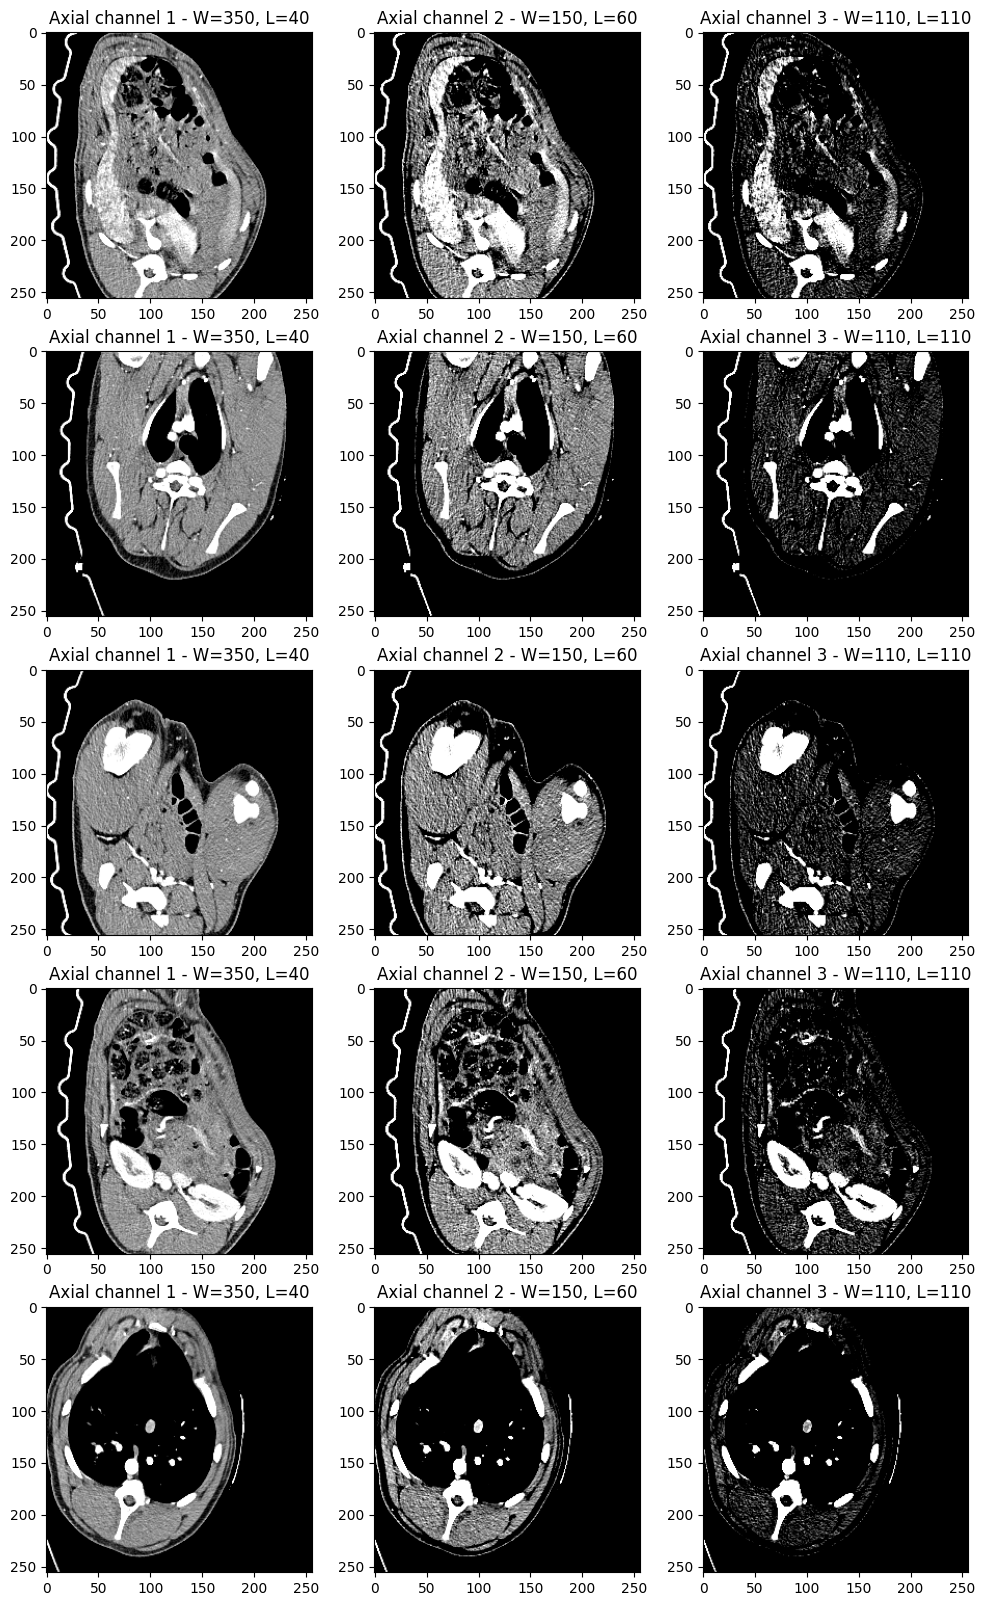

(256, 256, 128, 2) 0.0 1.0
(256, 256, 128, 2) 0.0 1.0
(256, 256, 128, 2) 0.0 1.0
(256, 256, 128, 2) 0.0 1.0
(256, 256, 128, 2) 0.0 1.0


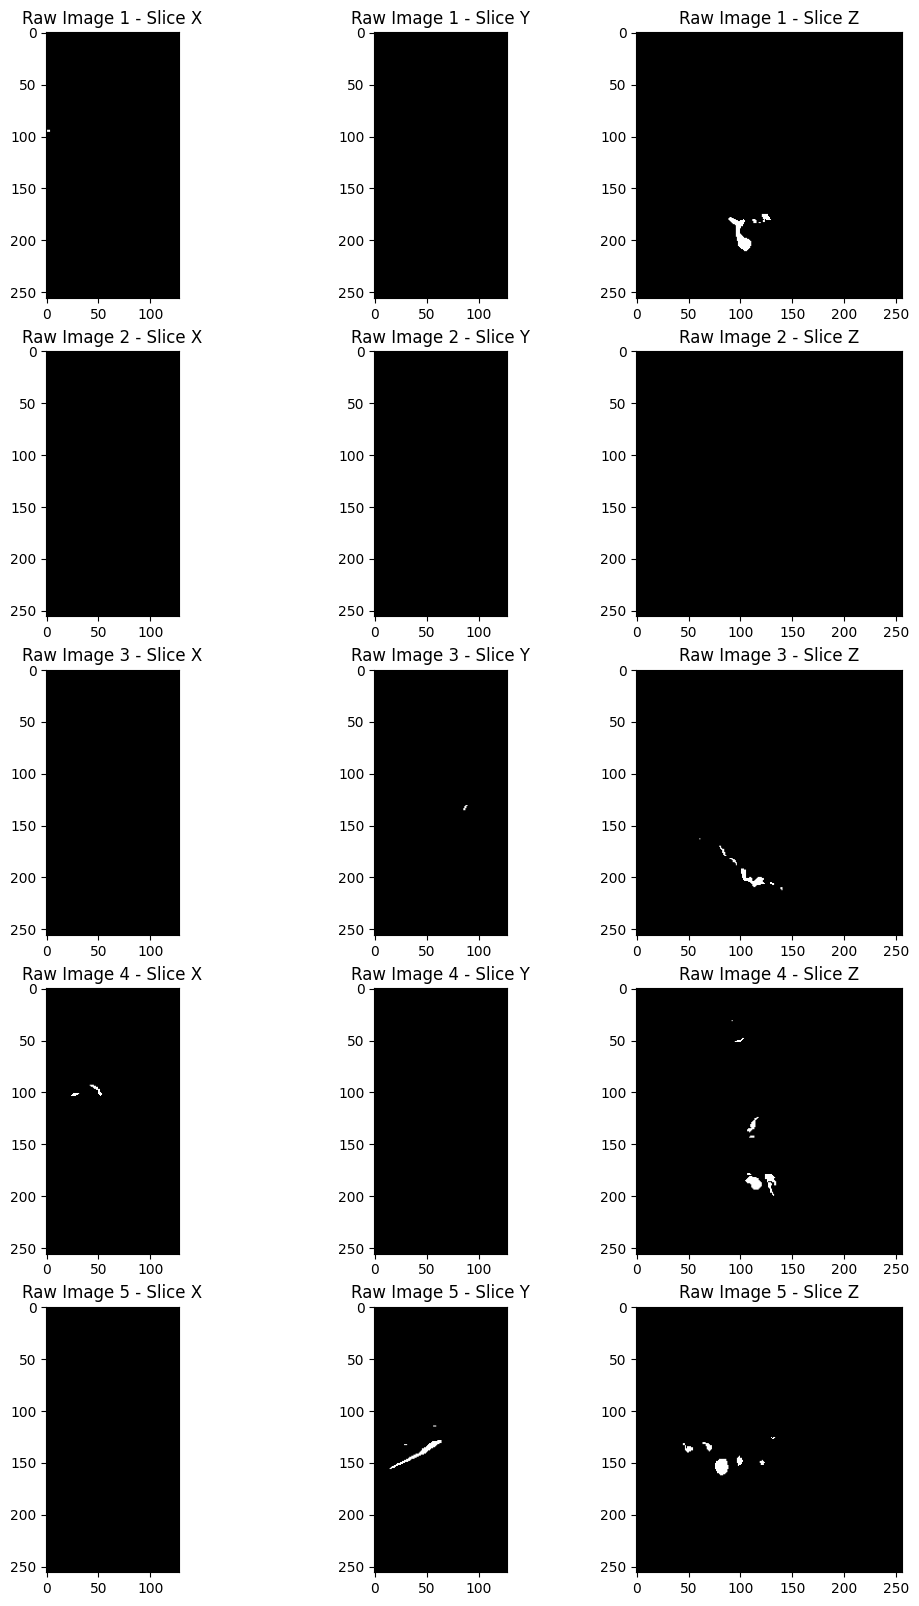

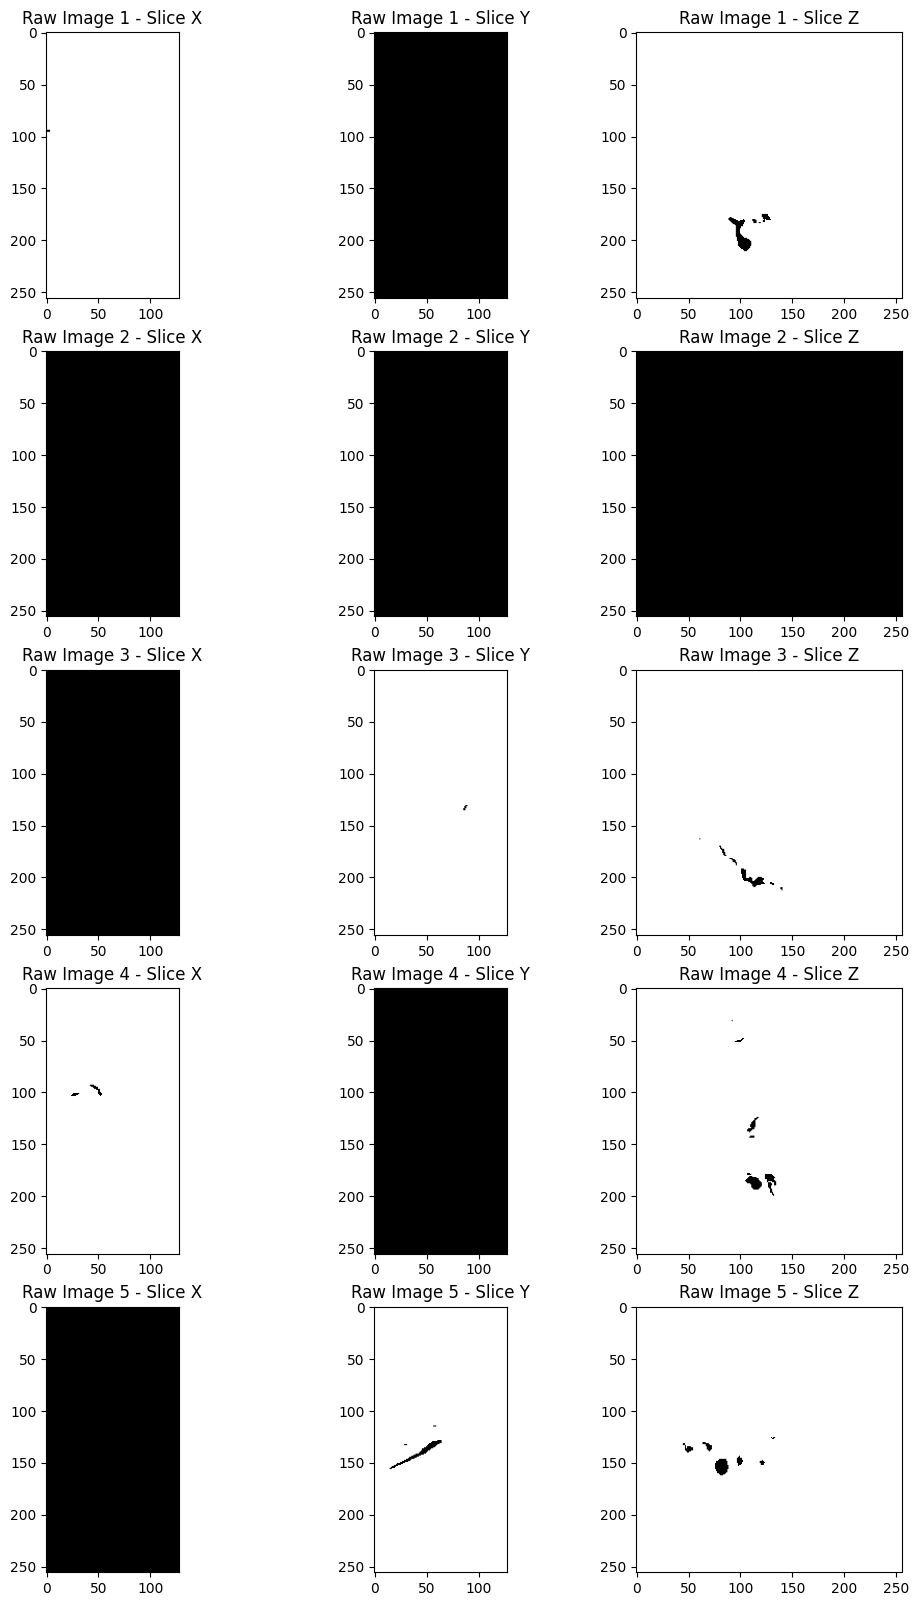

In [29]:
visualize_batch(batch_x, batch_y)

# Train UNET_3D

In [14]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2025-05-14 07:09:17.422286: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2432] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 6.1. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-05-14 07:09:17.422568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2432] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 6.1. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-05-14 07:09:17.862768: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2432] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 6.1. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-05-14 07:09:17.863030: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2432] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 6.1. CUDA kernels will be jit-compiled from PTX, whi

Num GPUs Available:  2


In [15]:
from tensorflow.keras import backend as K
from tensorflow.keras import Model, layers, mixed_precision
#from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal

In [16]:
# Metrics

# Dice coefficient metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.cast(K.flatten(y_true), dtype=K.floatx())
    y_pred_f = K.cast(K.flatten(y_pred), dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Additional segmentation metrics
def precision(y_true, y_pred):
    y_pred_bin = K.round(y_pred)
    true_positives = K.sum(y_true * y_pred_bin)
    predicted_positives = K.sum(y_pred_bin)
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    y_pred_bin = K.round(y_pred)
    true_positives = K.sum(y_true * y_pred_bin)
    possible_positives = K.sum(y_true)
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())

In [17]:
from tensorflow.keras import backend as K

def dice_coef_loss(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice


def focal_tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7, gamma=0.75, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    TP = K.sum(y_true_f * y_pred_f)
    FP = K.sum((1 - y_true_f) * y_pred_f)
    FN = K.sum(y_true_f * (1 - y_pred_f))
    
    tversky_index = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return K.pow((1 - tversky_index), gamma)


def tversky_loss(y_true, y_pred, alpha=0.4, beta=0.6, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    TP = K.sum(y_true_f * y_pred_f)
    FP = K.sum((1 - y_true_f) * y_pred_f)
    FN = K.sum(y_true_f * (1 - y_pred_f))
    
    return 1 - ((TP + smooth) / (TP + alpha * FP + beta * FN + smooth))


def jaccard_loss(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return 1 - ((intersection + smooth) / (union + smooth))


def weighted_binary_crossentropy(y_true, y_pred):
    # Default weights (used if not explicitly set)
    default_weights = [1.0, 1.0]  # Default: equal weight for both classes
    weights = getattr(weighted_binary_crossentropy, "weights", default_weights)

    weight_positive, weight_negative = weights

    # Convert to float tensors
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())

    # Avoid log(0)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

    # Compute weighted binary crossentropy loss
    loss = - (weight_positive * y_true * K.log(y_pred) + 
              weight_negative * (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(loss)

In [18]:
def conv_block(x, filters, n_convs, kernel_initializer, dropout_rate):
    for _ in range(n_convs):
        x = layers.Conv3D(filters, (3, 3, 3), activation='relu', padding='same',
                          kernel_initializer=kernel_initializer)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def get_3d_unet(shape=(128, 128, 128), n_convs_per_block=4):
    tf.keras.backend.set_image_data_format('channels_last')
    seed = 42
    tf.random.set_seed(seed)
    init = HeNormal(seed=seed)
    inputs = layers.Input(shape=(*shape, 3))

    # Encoder
    filters = [8, 16, 32, 64, 128]
    encoders = []
    x = inputs
    for f in filters:
        x = conv_block(x, f, n_convs_per_block, init, dropout_rate=0.2)
        encoders.append(x)
        x = layers.MaxPooling3D((2, 2, 2))(x)

    # Bottleneck
    x = conv_block(x, 256, n_convs_per_block, init, dropout_rate=0.3)

    # Decoder
    for i, f in reversed(list(enumerate(filters))):
        x = layers.Conv3DTranspose(f, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
        x = layers.concatenate([x, encoders[i]])
        x = conv_block(x, f, n_convs_per_block, init, dropout_rate=0.2)

    outputs = layers.Conv3D(2, (1, 1, 1), activation='sigmoid')(x)
    return Model(inputs, outputs)


## Train

In [23]:
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

In [24]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login() # 784560b40ab4e2961fe5d43ab8bf11739e40cabf

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romova9 (romova9-university-of-west-bohemia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [37]:
num_cykles = 200
num_epoch = 20
batch_size = 4

weighted_binary_crossentropy.weights = [10,5000]
shape = (256,256,128) #128^3

task = 'pilsen_pigs' # pisen_pigs, deepvesselnet, ircad
loss_func = weighted_binary_crossentropy
learning_rate = 0.001

In [38]:
train_generator, test_generator, train_steps, test_steps = data_generator(task=task, batch_size=batch_size, shape=shape)

ct_ids_train:  ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']

ct_ids_test:  ['Tx021D_Ven', 'Tx040D_Art']



In [39]:
text_to_save = task + '_channels_big'
print("text_to_save: \t" + text_to_save)

project_text = '3D_UNET_final'
print("project_text: \t" + project_text)

# Initialize W&B
wandb_log = project_text+"/"+text_to_save+".txt"
print("wandb_log: \t" + wandb_log)

text_to_save: 	pilsen_pigs_channels_big
project_text: 	3D_UNET_final
wandb_log: 	3D_UNET_final/pilsen_pigs_channels_big.txt


In [40]:
'''x, y = next(test_generator)
print(x.shape, y.shape)
plt.subplot(121), plt.imshow(x[0,30,:,:,0], cmap='gray')
plt.subplot(122), plt.imshow(y[0,30,:,:,0], cmap='gray'), plt.show()'''

"x, y = next(test_generator)\nprint(x.shape, y.shape)\nplt.subplot(121), plt.imshow(x[0,30,:,:,0], cmap='gray')\nplt.subplot(122), plt.imshow(y[0,30,:,:,0], cmap='gray'), plt.show()"

### New model

In [27]:
# Create and compile the model inside strategy's scope

with strategy.scope():
    model = get_3d_unet(shape=shape)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7),  # SGD(), tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7)
        loss=loss_func,
        metrics=[
            tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1], name="iou_foreground"),
            tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0], name="iou_background"),
            dice_coef,
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            precision,
            recall,
            f1_score
        ]
    )
    #lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

wandb.init(
    project=project_text,
    name=text_to_save,
    config={
        "experiment_name": text_to_save,
        "input_size":shape,
        #"ct_ids_train": ct_ids_train,
        #"ct_ids_test": ct_ids_test,
        "batch_size": batch_size,
        "epochs": num_epoch,
        "num_cykles": num_cykles,
        "class_weights": weighted_binary_crossentropy.weights,
        "learning_rate": learning_rate,
        "model_architecture": "3D U-Net",
        "optimizer": "Adam",
        "loss_function": loss_func,
        "metrics": ["IoU_background", "IoU_foreground", "DiceCoef", "Accuracy", "Precision", "Recall", "F1-score"]
    }
)

# Uložit run ID do souboru pro budoucí použití
os.makedirs(os.path.dirname(wandb_log), exist_ok=True) # Make directory if does not exists
with open(wandb_log, "w") as f:
    f.write(wandb.run.id)

### re-Train

In [ ]:
# For retrain: log to original wandb and load last saved model

model_name = project_text+"/"+text_to_save+"_cycle_2.h5"

with strategy.scope():
    # Define custom objects
    custom_objects = {
        "dice_coef": dice_coef,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "weighted_binary_crossentropy": weighted_binary_crossentropy
    }
    # Load the model with custom objects
    model = tf.keras.models.load_model(model_name, custom_objects=custom_objects)
print("model_name: ", model_name)

# Retrain
with open(wandb_log, "r") as f:
    run_id = f.read().strip()
print("run_id: ",run_id)
#run_id = "cs48nwd0"
    
wandb.init(
    project=project_text,
    name=text_to_save,
    id=run_id,  # Použití stejného ID
    resume="must",  # W&B musí pokračovat v běhu
    config={
        "experiment_name": text_to_save,
        "input_size":shape,
        #"ct_ids_train": ct_ids_train,
        #"ct_ids_test": ct_ids_test,
        "batch_size": batch_size,
        "epochs": num_epoch,
        "num_cykles": num_cykles,
        "class_weights": weighted_binary_crossentropy.weights,
        "learning_rate": learning_rate,
        "model_architecture": "3D U-Net",
        "optimizer": "Adam",
        "loss_function": loss_func,
        "metrics": ["IoU_background", "IoU_foreground", "DiceCoef", "Accuracy", "Precision", "Recall", "F1-score"]
    }
)

### Fit

In [ ]:
for i in range(0,num_cykles):
    print(f"\n--- Training cycle {i + 1}/{num_cykles} ---\n")

    # Trénování modelu s W&B callbackem
    history = model.fit(
        train_generator,
        epochs=num_epoch,
        steps_per_epoch=train_steps,
        validation_data=test_generator,
        validation_steps=test_steps,
        verbose=1,
        callbacks=[
            WandbCallback(
                save_model=False,  # Nebo True, pokud chceš ukládat model do W&B
                log_weights=True,
                log_gradients=False,  # True, pokud tě zajímají i gradienty
                log_evaluation=True   # Vyhodnocení val datasetu
            )
        ]
    )

    # Uložení modelu lokálně
    model.save(f"{project_text}/{text_to_save}_cycle_{i + 1}.h5")

# Ukončení runu
wandb.finish()

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.



--- Training cycle 1/200 ---



In [ ]:
print(text_to_save)
print(i)

# Vyhodnoceni

In [25]:
import pandas as pd

In [ ]:
# NLoad saved model

with strategy.scope():
    # Define custom objects
    custom_objects = {
        "dice_coef": dice_coef,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "weighted_binary_crossentropy": weighted_binary_crossentropy
    }
    # Load the model with custom objects
    #model = tf.keras.models.load_model(project_text+"/"+text_to_save+"_processor.h5", custom_objects=custom_objects)
    model = tf.keras.models.load_model("3D_UNET_final/pisen_pigs_big:weight__cycle_37.h5", custom_objects=custom_objects)

In [ ]:
model.summary()

In [56]:
# Prepare image generators
batch_size=5
shape = (256,256,128) #128^3
task = 'pilsen_pigs' # pisen_pigs, deepvesselnet, ircad

train_generator, test_generator, train_steps, test_steps = data_generator(task=task, batch_size=batch_size, shape=shape)

print("ct_ids_train: ", ct_ids_train)
print()
print("ct_ids_test: ", ct_ids_test)

ct_ids_train:  ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']

ct_ids_test:  ['Tx021D_Ven', 'Tx040D_Art']

ct_ids_train:  ['Tx025D_Ven', 'Tx017D_Art', 'Tx023D_Ven', 'Tx019D_Ven', 'Tx025D_Art', 'Tx018D_Art']

ct_ids_test:  ['Tx021D_Ven', 'Tx024D_Art']


In [ ]:
# Evaluate the model
results_dict = {}
evaluation = model.evaluate(
    test_generator,
    steps=test_steps,  
    verbose=1  
)
# Get metric names from the model
metric_names = model.metrics_names  # e.g., ['loss', 'iou_background', ...]

# Collect results for each metric
for m, v in zip(metric_names, evaluation):
    if m not in results_dict:
        results_dict[m] = {}
    results_dict[m][text] = v

In [ ]:
# Create a DataFrame with metrics as rows and model names as columns
metrics_df = pd.DataFrame(results_dict).transpose()
print("Summary of all metrics:")
print(metrics_df)

In [ ]:
x, y = next(test_generator)
prediction = model.predict(
    x,  # Input data
    verbose=1
)
print(x.shape)
print(y.shape)
print(prediction.shape)

In [ ]:
image = 3
vrstva = 100

plt.figure(figsize=(12, 5))
plt.title(text_to_save)
plt.subplot(131).imshow(x[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(y[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(prediction_[image, vrstva,:,:,0], cmap='gray'), plt.title("Predikce"), plt.show()

In [ ]:
prediction_ = (prediction > 0.7).astype(np.float32)

In [ ]:
image =  4
vrstva = 120

plt.figure(figsize=(12, 5))
plt.title(text_to_save)
plt.subplot(131).imshow(x[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(y[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(prediction_[image, vrstva,:,:,0], cmap='gray'), plt.title("Predikce"), plt.show()

# Konkrétní snímek

In [19]:
import nibabel as nib
import numpy as np
from tensorflow.keras.models import Model
from tqdm import tqdm

def resample_to_voxelsize(volume, spacing, target_spacing=(1.0, 1.0, 1.0), order=3):
    """Resample volume to target voxel spacing using scipy zoom"""
    from scipy.ndimage import zoom
    resize_factors = np.array(spacing) / np.array(target_spacing)
    return zoom(volume, resize_factors, order=order)

def sliding_window_inference(nifti_path, model: Model, window_shape=(256, 256, 64), stride=(128, 128, 32)):
    """
    Apply a trained 3D model using sliding window inference on a NIfTI volume after preprocessing.

    Parameters:
        nifti_path (str): path to the CT scan (file name).
        model (Model): Trained Keras model.
        window_shape (tuple): Shape of the sliding window.
        stride (tuple): Step size of sliding window.
    
    Returns:
        output_volume (np.ndarray): Prediction mask for the entire volume.
    """
    nifti_path = Path(nifti_path)
    
    # === 1. Load NIfTI file ===
    raw_nii = nib.load(nifti_path)
    raw = raw_nii.get_fdata()
    spacing = raw_nii.header.get_zooms()[:3]  # (z, y, x)

    mask_nii = nib.load(nifti_path.parent / 'artery.nii.gz')
    mask = mask_nii.get_fdata()
    mask = (mask > 0.5).astype(np.float32)

    # === 2. Apply windowing (CT intensity range) ===
    raw = window(raw, center=40, width=400)

    # === 3. Resample to isotropic voxels ===
    raw = resample_to_voxelsize(raw, spacing, target_spacing=(1.0, 1.0, 1.0), order=3)
    mask = resample_to_voxelsize(mask, spacing, target_spacing=(1.0, 1.0, 1.0), order=0)
    
    # === 4. Normalize and expand to 3 channels ===
    raw = (raw - np.min(raw)) / (np.max(raw) - np.min(raw) + 1e-5)
    raw = np.stack([raw] * 3, axis=-1)  # From (Z, Y, X) to (Z, Y, X, 3)
    
    background = 1.0 - mask
    mask = np.stack([mask, background], axis=-1)

    original_shape = raw.shape[:-1]

    # === 5. Padding ===
    pad_width = [
        (0, max(0, window_shape[0] - original_shape[0] % stride[0])),
        (0, max(0, window_shape[1] - original_shape[1] % stride[1])),
        (0, max(0, window_shape[2] - original_shape[2] % stride[2])),
        (0, 0)
    ]
    volume_padded = np.pad(raw, pad_width, mode='constant')
    padded_shape = volume_padded.shape

    output = np.zeros(padded_shape[:-1], dtype=np.float32)
    count_map = np.zeros(padded_shape[:-1], dtype=np.float32)

    # === 6. Sliding window inference ===
    for z in tqdm(range(0, padded_shape[0] - window_shape[0] + 1, stride[0])):
        for y in range(0, padded_shape[1] - window_shape[1] + 1, stride[1]):
            for x in range(0, padded_shape[2] - window_shape[2] + 1, stride[2]):
                patch = volume_padded[z:z+window_shape[0],
                                      y:y+window_shape[1],
                                      x:x+window_shape[2], :]

                patch_input = np.expand_dims(patch, axis=0)  # Batch dim
                prediction = model.predict(patch_input, verbose=0)[0]

                output[z:z+window_shape[0],
                       y:y+window_shape[1],
                       x:x+window_shape[2]] += prediction[..., 0]
                count_map[z:z+window_shape[0],
                          y:y+window_shape[1],
                          x:x+window_shape[2]] += 1

    output /= np.maximum(count_map, 1e-5)
    output = output[:original_shape[0], :original_shape[1], :original_shape[2]]

    return raw, mask, output

In [ ]:
# NLoad saved model
with strategy.scope():
    # Define custom objects
    custom_objects = {
        "dice_coef": dice_coef,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "weighted_binary_crossentropy": weighted_binary_crossentropy
    }
    # Load the model with custom objects
    #model = tf.keras.models.load_model(project_text+"/"+text_to_save+"_processor.h5", custom_objects=custom_objects)
    loaded_model = tf.keras.models.load_model("3D_UNET_final/pisen_pigs_small_cycle_76.h5", custom_objects=custom_objects)

In [ ]:
raw, mask, output = sliding_window_inference(
    nifti_path="2D_to_3D/data/pilsen_pigs/Tx023D_Ven/Tx023D_Ven.nii.gz",
    model=loaded_model,
    window_shape=(128, 128, 128),
    stride=(64, 64, 64)
)

In [ ]:
print("raw: ", raw.shape)
print("mask: ", mask.shape)
print("output: ", output.shape)

In [ ]:
vrstva = 220

plt.figure(figsize=(12, 5))
#plt.title(text_to_save)
plt.subplot(131).imshow(raw[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(mask[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(output[vrstva,:,:], cmap='gray'), plt.title("Predikce"), plt.show()

In [ ]:
output_ = (output > 0.2).astype(np.float32)

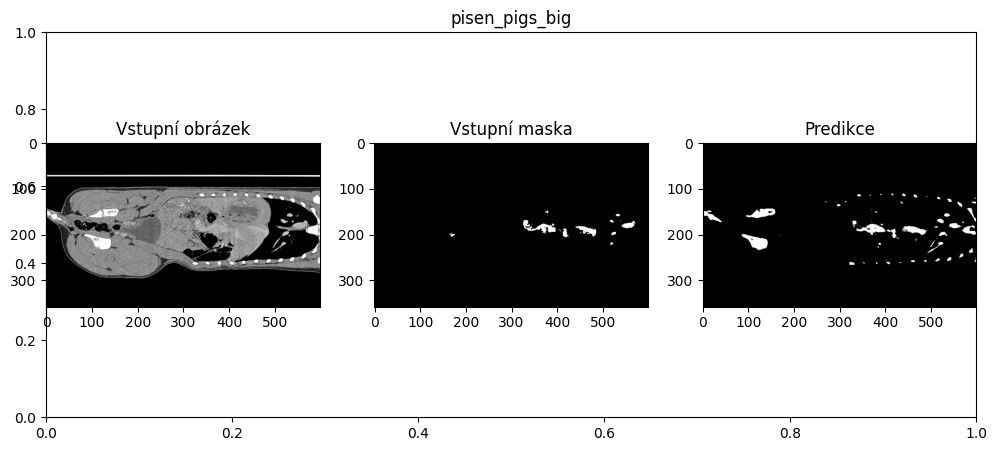

(<matplotlib.image.AxesImage at 0x14d12a0f58b0>,
 Text(0.5, 1.0, 'Predikce'),
 None)

In [220]:
vrstva = 200

plt.figure(figsize=(12, 5))
plt.title(text_to_save)
plt.subplot(131).imshow(raw[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(mask[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(output_[vrstva,:,:], cmap='gray'), plt.title("Predikce"), plt.show()

In [221]:
output_dir = Path('predikce')
os.makedirs(os.path.dirname(output_dir), exist_ok=True) # Make directory if does not exists
    
# If you have an affine from the original scan, use it. Otherwise use identity
affine = np.eye(4)

# Create and save NIfTI files
nib.save(nib.Nifti1Image(raw[...,0], affine), output_dir/'raw.nii.gz')
nib.save(nib.Nifti1Image(mask[...,0], affine), output_dir/'mask.nii.gz')
nib.save(nib.Nifti1Image(output_, affine), output_dir/'output.nii.gz')

print("NIfTI files saved successfully.")

NIfTI files saved successfully.


In [222]:
import zipfile
#import shutil

# Create ZIP file of the output directory
zip_path = output_dir.with_suffix('.zip')
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in output_dir.glob('*'):
        zipf.write(file, arcname=file.name)

print(f"Directory zipped successfully at: {zip_path}")

Directory zipped successfully at: 2D_to_3D/predikce.zip
